Found 2357 files belonging to 2 classes.
Using 1886 files for training.
Found 2357 files belonging to 2 classes.
Using 471 files for validation.
Number of classes: 2
Class names: ['Test', 'Train']
Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8842 - loss: 0.6484 - val_accuracy: 0.9406 - val_loss: 0.2431
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9470 - loss: 0.2192 - val_accuracy: 0.9406 - val_loss: 0.2911
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9495 - loss: 0.2085 - val_accuracy: 0.9406 - val_loss: 0.2842
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.9565 - loss: 0.1884 - val_accuracy: 0.9257 - val_loss: 0.2577
Epoch 5/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9595 - loss: 0.1749 - val_accuracy: 0.9406 - val_loss: 0.2526
Epoch 6/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9595 - loss: 0.1707 - val_accuracy: 0.9384 - val_loss: 0.2535
Epoch 7/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/

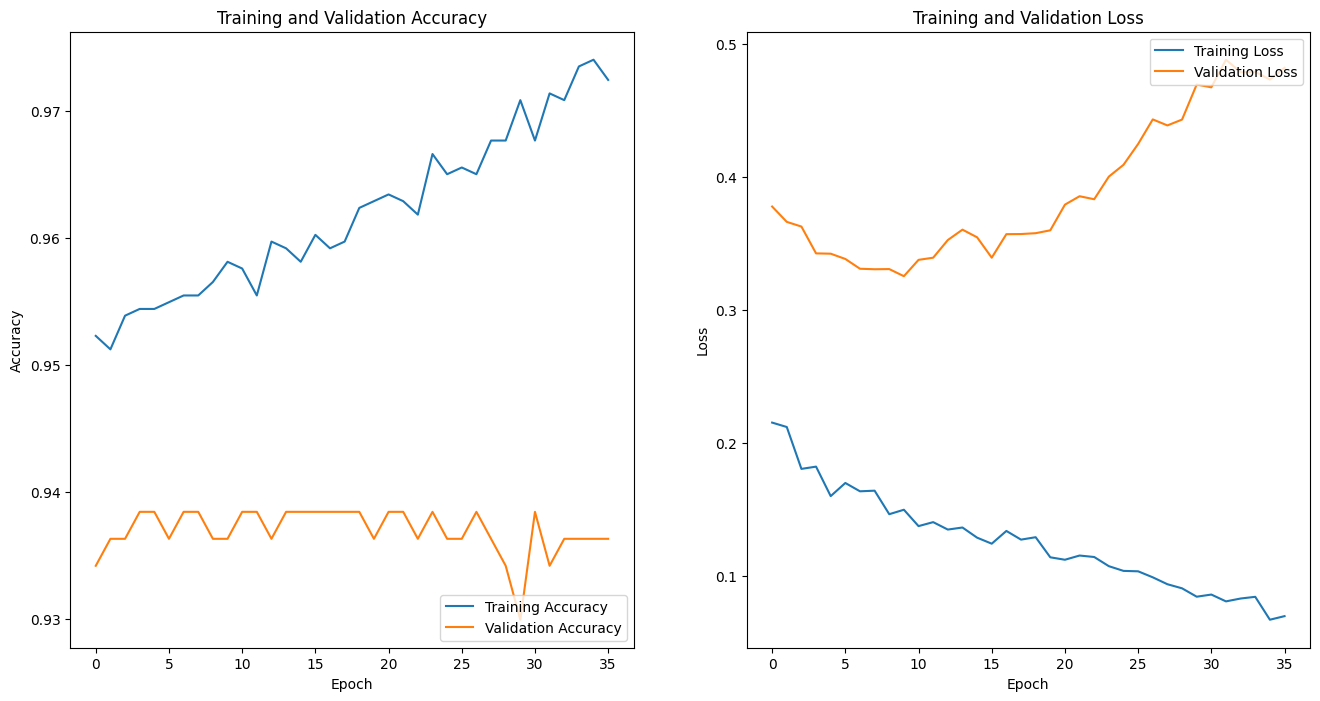

15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9478 - loss: 0.3848
Validation accuracy: 0.94


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

# Define the path to your dataset
data_dir = r"D:\Amrita Documents\College\Semester 7\Mobile App Dev\Projec\Dataset\archive\Skin cancer ISIC The International Skin Imaging Collaboration"

# Define image dimensions and batch size
img_height = 180
img_width = 180
batch_size = 32

# Create training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Load the ResNet101V2 model pre-trained on ImageNet data
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Enhanced data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

# Create the model using Functional API
inputs = Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0/255)(x)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model with initial settings
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model initially with frozen ResNet101V2 layers
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Fine-tuning: Unfreeze some layers in the base model
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Re-compile the model for fine-tuning with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Continue training the model for fine-tuning
fine_tune_epochs = 35
total_epochs = epochs + fine_tune_epochs
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)

# Function to plot training history
def plot_fine_tuning_history(history_fine):
    acc = history_fine.history['accuracy']
    val_acc = history_fine.history['val_accuracy']
    loss = history_fine.history['loss']
    val_loss = history_fine.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.show()

# Plot the training history
plot_fine_tuning_history(history_fine)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy:.2f}")

# Function to make predictions on a single image
def predict_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class = class_names[tf.argmax(score)]
    confidence = 100 * tf.reduce_max(score)
    return predicted_class, confidence

# Test the model on some images from the dataset
test_dir = os.path.join(data_dir, 'test')  # Assuming there's a 'test' folder in your dataset
test_images = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]

for img_path in test_images[:5]:  # Test on first 5 images
    predicted_class, confidence = predict_image(img_path)
    print(f"Image: {img_path}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%\n")

Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9728 - loss: 0.0713 - val_accuracy: 0.9363 - val_loss: 0.5070
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9758 - loss: 0.0676 - val_accuracy: 0.9363 - val_loss: 0.5338
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9815 - loss: 0.0592 - val_accuracy: 0.9384 - val_loss: 0.5315
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9800 - loss: 0.0638 - val_accuracy: 0.9384 - val_loss: 0.5210
Epoch 5/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9769 - loss: 0.0625 - val_accuracy: 0.9384 - val_loss: 0.5189
Epoch 6/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9756 - loss: 0.0723 - val_accuracy: 0.9363 - val_loss: 0.5383
Epoch 7/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9811 - loss: 0.0546 - val_accuracy: 0.9363 - val_loss: 0.5380
Epoch 8/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9782 - loss: 0.0516 - val_accuracy: 0.9278 - v

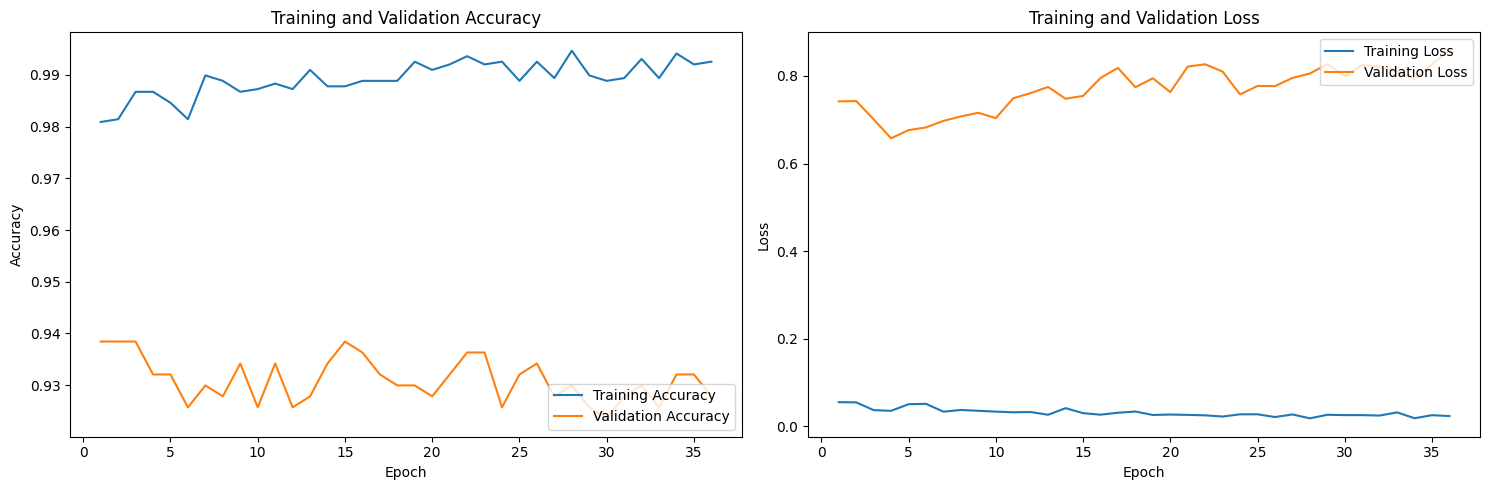

Evaluating model on validation set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


NameError: name 'np' is not defined

In [5]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Fine-tuning: Unfreeze some layers in the base model
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Re-compile the model for fine-tuning with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Continue training the model for fine-tuning
fine_tune_epochs = 35
total_epochs = epochs + fine_tune_epochs
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)

# Function to plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history_fine)

# Function to calculate F1 score and create confusion matrix
def evaluate_model(model, dataset, class_names):
    y_pred = []
    y_true = []

    for image_batch, label_batch in dataset:
        pred_batch = model.predict(image_batch)
        y_pred.extend(np.argmax(pred_batch, axis=1))
        y_true.extend(label_batch.numpy())

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"F1 Score: {f1:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Evaluate the model
print("Evaluating model on validation set:")
evaluate_model(model, val_ds, class_names)

# Function to make predictions on a single image
def predict_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class = class_names[tf.argmax(score)]
    confidence = 100 * tf.reduce_max(score)
    return predicted_class, confidence

# Test the model on some images from the dataset
test_dir = os.path.join(data_dir, 'test')  # Assuming there's a 'test' folder in your dataset
test_images = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]

for img_path in test_images[:5]:  # Test on first 5 images
    predicted_class, confidence = predict_image(img_path)
    print(f"Image: {img_path}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%\n")

Plot created successfully.


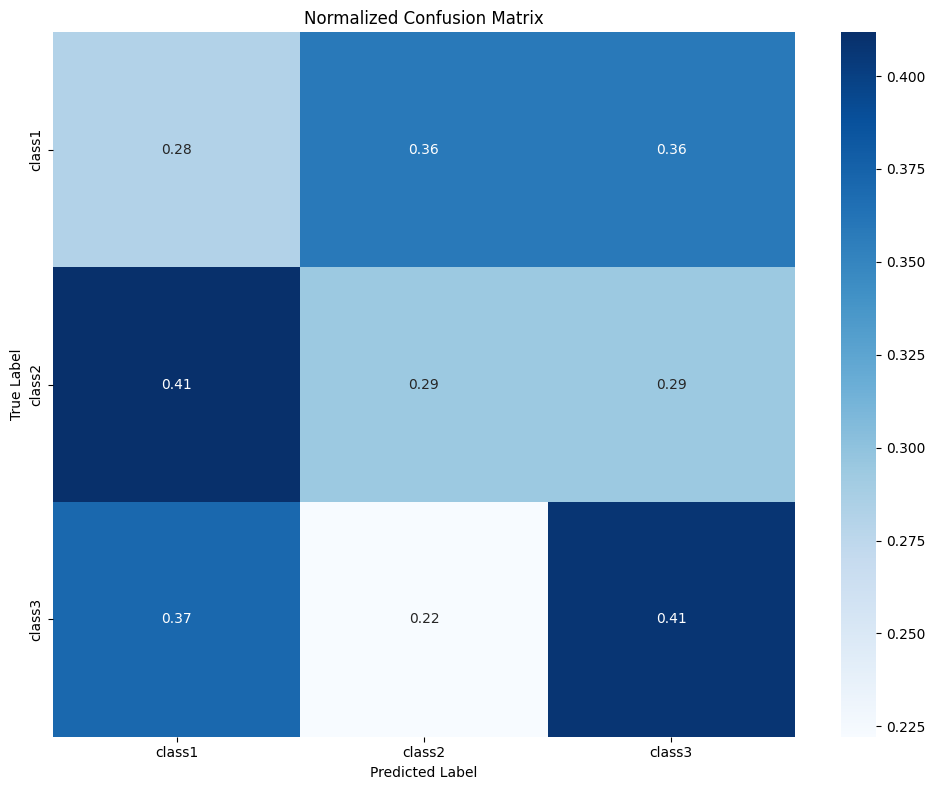

Plot should be displayed now.
Current matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot a confusion matrix for a classification model.
    
    Parameters:
    y_true (array-like): True labels
    y_pred (array-like): Predicted labels
    classes (list): List of class names
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    
    # Debugging: Print to confirm the plot is created
    print("Plot created successfully.")
    
    # Try to show the plot
    try:
        plt.show()
        print("Plot should be displayed now.")
    except Exception as e:
        print(f"Error displaying plot: {e}")
        print("Trying alternative display method...")
        
        # Alternative: Save the plot as an image file
        try:
            plt.savefig('confusion_matrix.png')
            print("Plot saved as 'confusion_matrix.png'")
        except Exception as e:
            print(f"Error saving plot: {e}")

# Example usage:
# Assuming you have your true labels (y_true) and predicted labels (y_pred)
# class_names = ['class1', 'class2', 'class3', ...]  # Your actual class names

# Generate some dummy data for demonstration
np.random.seed(0)
y_true = np.random.randint(0, 3, 100)
y_pred = np.random.randint(0, 3, 100)
class_names = ['class1', 'class2', 'class3']

# Call the function
plot_confusion_matrix(y_true, y_pred, class_names)

# Additional debugging: Check matplotlib backend
print(f"Current matplotlib backend: {plt.get_backend()}")
